# Before you start with this Model Retraining Notebook

This notebook is part of the Vectice tutorial project notebook series. It illustrates how to log the assets documented in the "Model Retraining" phase of the **"Tutorial: Forecast in store-unit sales (xxxx/xx/xx)"** project you can find in your personal Vectice workspace.

### Pre-requisites:
Before using this notebook you will need:
* An account in Vectice
* An API token to connect to Vectice through the APIs
* The Phase Id of the project where you want to log your work

Refer to Vectice Getting Started Guide for more detailed instructions: https://docs.vectice.com/getting-started/


### Other Resources
*   Vectice Documentation: https://docs.vectice.com/ </br>
*   Vectice API documentation: https://api-docs.vectice.com/

## We assume in this exercise that we want to retrain the model because the variable 'postal code' was left accidentally inside our initial modeling dataset

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Install the latest Vectice Python client library

In [ ]:
%pip install --q vectice -U
%pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Get started by connecting to Vectice

You can learn more about the `Connection` object in the [documentation](https://api-docs.vectice.com/reference/vectice/connection/)

<div class="alert" style="color: #383d41; background-color: #e2e3e5; border-color: #d6d8db" role="alert">
<b>Automated code lineage:</b> The code lineage functionalities are not covered as part of this Tutorial as they require to first setting up a Git repository.
</div>

**First, we need to authenticate to the Vectice server. Before proceeding further:**

- Visit the Vectice app (https://docs.vectice.com/getting-started/create-an-api-token) to create and copy an API token.

- Paste the API token in the code below

In [27]:
import vectice

vec = vectice.connect(api_token="my-api-token") #Paste your API token

VECTICE_API_ENDPOINT is deprecated and will be removed in 23.3.1.0, please use VECTICE_HOST instead.
Welcome, bdaversa. You`re now successfully connected to Vectice.

To access your personal workspace, use connection.my_workspace
To access a specific workspace, use connection.workspace(Workspace ID)
To get a list of workspaces you can access and their IDs, use connection.list_workspaces()

If you are using a notebook you can call the help by using a Vectice returned object with the builtin notebook "?":
>> connection?

If you are using an IDE you can call the help() method on any object returned by Vectice:
>> help(connection)

For quick access to your default workspace in the Vectice web app, visit:
https://qa.vectice.com/browse/workspace/WSP-309


## Specify which project phase you want to document
In Vectice UI, navigate to your personal workspace, inside your default Tutorial project go to the Model Retraining phase you just created and copy paste your Phase Id below.

In [30]:
phase = vec.phase("PHA-xxxx") # Paste your own Model Retraining phase ID

Phase 'Modeling Retraining' successfully retrieved."

For quick access to the Phase in the Vectice web app, visit:
https://qa.vectice.com/browse/phase/PHA-5859


## Next we are going to create an iteration
An iteration allows you to organize your work in repeatable sequences of steps. You can have multiple iteration within a phase

In [31]:
model_iteration = phase.create_iteration()

New Iteration number '1' created.

For quick access to the Iteration in the Vectice web app, visit:
https://qa.vectice.com/browse/iteration/ITR-2258


## Retrieve your cleaned Dataset previously created in phase Data Preparation for your lineage
You can retrieve a variety of Vectice Objects with the `browse('VECTICE-ID')` method. Namely, Phases, Iterations, Datasets, Models etc...

Inside your project, go to the Dataset tab and look for "ProductSales Cleaned" to get the Vectice ID. This is the Wrapped Dataset created in the Data Preparation phase and will be useful for the lineage.

In [32]:
cleaned_ds = vec.browse("DTS-xxxx") #Get the ID of your Clean Dataset created in the Data Preparation phase

Dataset 'ProductSales Cleaned' successfully retrieved."

For quick access to the Dataset in the Vectice web app, visit:
https://qa.vectice.com/browse/dataset/DTS-3124


## Log a Dataset version

Use the following code block to create a local Dataset we assume that the dataset contains data and we already cleaned it in the previous phases

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/vectice/GettingStarted/main/23.2/tutorial/ProductSales%20Cleaned.csv", converters = {'Postal Code': str})
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,others,others,42420,South,Furniture,Bookcases,261.960,2,0.0,41.9136
1,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.620,2,0.0,6.8714
2,Standard Class,Consumer,United States,others,Florida,33311,South,Office Supplies,Storage,22.368,2,0.2,2.5164
3,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,Furnishings,48.860,7,0.0,14.1694
4,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Art,7.280,4,0.0,1.9656


## Remove Postal code

In [3]:
X = df.drop(["Sales", "Postal Code"],axis=1)
y = df["Sales"]
print(X.shape)
print(y.shape)

(7994, 11)
(7994,)


In [4]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Save the modeling train test split datasets as csv files
train_df = X_train.copy()
test_df = X_test.copy()

train_df["Sales"] = y_train
test_df["Sales"] = y_test

train_df.to_csv("train dataset.csv", index=False)
test_df.to_csv("test dataset.csv", index=False)

### Log dataset metadata and statistics
Log dataset metadata and statistics to Vectice by passing the file resource path and a `Pandas.DataFrame`

In [37]:
train_ds = vectice.FileResource(paths="train dataset.csv", dataframes=train_df)
test_ds = vectice.FileResource(paths="test dataset.csv", dataframes=test_df)

File: train dataset.csv wrapped successfully.
File: test dataset.csv wrapped successfully.


In [38]:
modeling_dataset = vectice.Dataset.modeling(
        name="ProductSales Modeling",
        training_resource=train_ds,
        testing_resource=test_ds, 
        derived_from=cleaned_ds,
    )

## Log the Dataset version
Since metadata for the modeling Dataset has changed, Vectice will automatically create a new version of the existing ProductSales Modeling Dataset with the updated metadata

In [39]:
model_iteration.step_model_input_data = modeling_dataset

New Version: 'Version 2' of Dataset: 'ProductSales Modeling' added to Step: Model Input Data
Attachments: None
Link to Step: https://qa.vectice.com/browse/iteration/ITR-2258



### Retrain a Ridge regressor

In [6]:
OHE = OneHotEncoder(handle_unknown='infrequent_if_exist')
scaler = StandardScaler()

cat_cols = ['Ship Mode', 'Segment', 'Country', 'City', 'State','Region', 'Category', 'Sub-Category']
num_cols = ['Quantity', 'Discount', 'Profit']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)])

model = make_pipeline(transformer,Ridge())
model.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Ship Mode', 'Segment',
                                                   'Country', 'City', 'State',
                                                   'Region', 'Category',
                                                   'Sub-Category']),
                                                 ('num_cols', StandardScaler(),
                                                  ['Quantity', 'Discount',
                                                   'Profit'])])),
                ('ridge', Ridge())])

In [7]:
# Making Prediction with the training data
y_train_pred = model.predict(X_train)
#Evaluating the model 
mae_train=mean_absolute_error(y_train, y_train_pred)
print(round(mae_train,2))

59.31


In [8]:
# Making Prediction with the testing data
y_test_pred = model.predict(X_test)
#Evaluating the model 
mae_test = mean_absolute_error(y_test, y_test_pred)
print(round(mae_test,2))

63.11


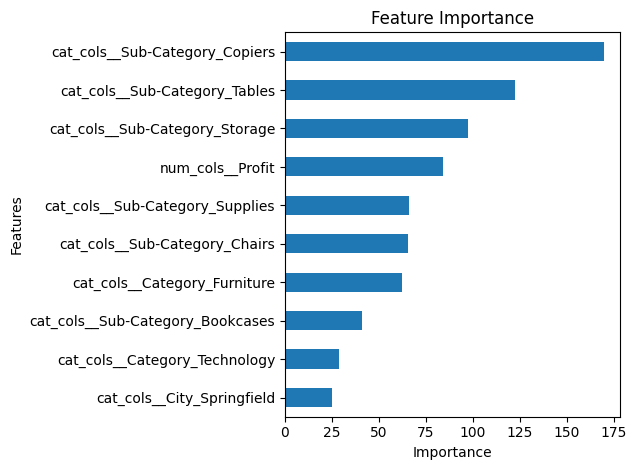

In [9]:
feature_names = transformer.get_feature_names_out()
feature_importances = model.named_steps['ridge'].coef_

feat_imf = pd.Series(feature_importances, index=feature_names).sort_values()

feat_imf.tail(10).plot(kind="barh")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("Feature Importance.png")

## Log a trained model with an attachment

Then we log a trained model to Vectice using the `Vectice.Model()` object.

In [44]:
vect_model = vectice.Model(library="scikit-learn", technique="Ridge Regression", metrics={"mae_train": round(mae_train,2), "mae_test": round(mae_test,2)}, 
                        properties=model.named_steps, predictor=model, derived_from=modeling_dataset, attachments="Feature Importance.png")

## Add the retrain model to the step
You can add multiple models to a single step by using the `+=` operator.

In [45]:
model_iteration.step_build_model += vect_model

Model Pipeline successfully attached to Model(name='scikit-learn Ridge Regression model', version='Version 2').
New Version: 'Version 2' of Model: 'scikit-learn Ridge Regression model' added to Step: Build Model
Attachments: Feature Importance.png
Link to Step: https://qa.vectice.com/browse/iteration/ITR-2258



## Add a comment 

Passing a `string` to a step will add a comment.

In [46]:
# Select the model to be staged
model_iteration.step_model_validation = f"Model passed acceptance criteria\nMAE Train: {round(mae_train,2)}\nMAE Test: {round(mae_test,2)}"

Added Comment to Step: Model Validation

Link to Step: https://qa.vectice.com/browse/iteration/ITR-2258



### Once you are statisfied with your iteration you can complete it so it can't be modified anymore and you can request a review

In [47]:
model_iteration.complete()

Iteration with index 1 completed.

For quick access to the Iteration in the Vectice web app, visit:
https://qa.vectice.com/browse/iteration/ITR-2258


✴ You can view your registered assets and comments in the UI by clicking the links in the output messages..